In [104]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torch.utils.data.dataset import random_split as split 
from sklearn.model_selection import train_test_split
import torch; from torch.utils.data import DataLoader, Dataset

import numpy as np 
import pandas as pd

print(torch.__version__)
print(torchaudio.__version__)
torch.random.manual_seed(0)

MIN_SAMPLES = True
PATH_ANNOTATIONS = 'Wingbeats/min_annotations.txt' if MIN_SAMPLES else 'Wingbeats/annotations.txt'
n_classes = 6
lr = 1e-4
n_epochs = 50
batch_size = 32
DURATION = 0.5

2.8.0+cu128
2.8.0+cu128


In [105]:
def dividirDatos(archivoAnnotaciones, test_size=0.2, random_state=42):
    df = pd.read_csv(archivoAnnotaciones)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size,
        random_state=random_state,
        stratify=df['label']
    )
    print('Total = ', len(df))
    print('Total train = ', len(train_df))
    print('Total test = ', len(test_df))
    return train_df, test_df

In [106]:
class AudioDatasetFromTxt(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        audio_path = self.dataframe.iloc[index]['file_path']
        label = self.dataframe.iloc[index]['label']
        
        waveform, _ = librosa.load(audio_path)
        
        waveform = torch.from_numpy(waveform).float().unsqueeze(0)
        
        if self.transform:
            spectrogram = self.transform(waveform)
            return spectrogram, label
        else:
            return waveform, label

In [107]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [108]:
train_df, test_df = dividirDatos(PATH_ANNOTATIONS)

Total =  115782
Total train =  92625
Total test =  23157


In [109]:
train_dataset = AudioDatasetFromTxt(train_df)
test_dataset = AudioDatasetFromTxt(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([1, 13782])
tensor([2, 5, 1, 2, 1, 5, 5, 5, 2, 4, 5, 4, 0, 4, 2, 4, 5, 4, 3, 5, 0, 3, 3, 0,
        2, 1, 4, 2, 4, 2, 4, 4])


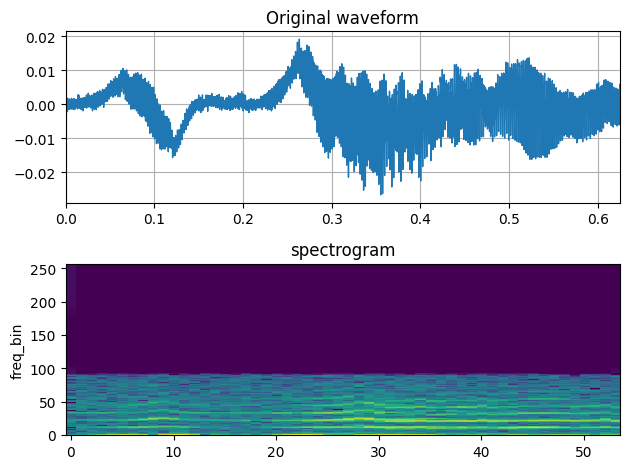

In [115]:
for data, label in train_loader:
    print(data[0].shape)
    print(label)
    spectrogram = T.Spectrogram(n_fft=512)
    spec = spectrogram(data[0])
    fig, axs = plt.subplots(2, 1)
    plot_waveform(data[0], 22050, title="Original waveform", ax=axs[0])
    plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
    fig.tight_layout()
    break